In [1]:
import dask.dataframe as dd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
current_year = datetime.now().year

In [3]:
def load_data(filepath: str):
    """Загружаем CSV файл в Dask DataFrame"""
    data = dd.read_csv(filepath, assume_missing=True)
    data = data[["brand", "year", "mileage", "body_type", "fuel_type",
                       "engine_volume", "engine_power", "transmission","drive", "wheel",
                       "state", "owners_count", "pts", "customs", "price"
                       ]]
    return data

In [4]:
def preprocess_partition(batch):
    """Обрабатываем каждую партицию: дропаем пропуски и дубликаты, делаем новые фичи"""
    batch = batch.dropna()
    batch = batch.drop_duplicates()
    batch["power_per_litre"] = batch["engine_power"] / batch["engine_volume"]
    # мощность двигателя относительно объема в литрах
    # насколько эффективно используется объем двигателя для генерации мощности

    batch['mean_mileage_per_year'] = batch['mileage'] / (current_year - batch['year']) 
    # средний пробег в год
    
    return batch

In [5]:
def split_data(df: dd.DataFrame):
    """Разделяет данные на обучающую и тестовую выборки"""
    train_df = df.partitions[0:17]
    test_df = df.partitions[18]
    return train_df, test_df

In [6]:
def train_catboost(filepath: str):
    """Функция обучения CatBoost по партициям"""
    # Параметры модели
    params = {
    'learning_rate': 0.05,
    'n_estimators': 400
    }
    # Инициализируем модель
    model = CatBoostRegressor(
        **params, verbose=50
    )

    partitions = filepath.to_delayed()

    for i, partition in enumerate(partitions):
        partition = partition.compute()  # Загружаем партицию в память (compute только для текущей)
        partition = preprocess_partition(partition)  # Обрабатываем партицию

        # Категориальные признаки
        cat_features = [x for x in partition.columns if partition[x].dtype=='string[pyarrow]']
        partition[cat_features] = partition[cat_features].apply(lambda x: x.astype('category'))

        feature_train = partition.drop(columns=["price"])
        target_train = partition["price"]

        if i == 0:
            model.fit(feature_train, target_train, cat_features=cat_features)  # Первый батч - обучаем модель с нуля
        else:
            model.fit(feature_train, target_train, cat_features=cat_features, 
                      init_model=model)  # Следующие партиции - дообучаем модель

    return model



In [7]:
def predict_in_partitions(model, test_df):
    """Функция для прогнозов на тестовых партициях"""
    predictions = []
    actuals = []

    for partition in test_df.to_delayed():
        batch = partition.compute()
        batch = preprocess_partition(batch)
        X_batch = batch.drop(columns=["price"])
        y_batch = batch["price"]

        y_pred = model.predict(X_batch)
        predictions.append(y_pred)
        actuals.append(y_batch.to_numpy())

    return np.concatenate(predictions), np.concatenate(actuals)

In [8]:
def calculate_metrics(y_pred, y_true):
    """Функция для расчета метрик"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = (np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print("Оценка тестового множества модели CatBoost:")
    print('MSE: {:.2f}'.format(mse))
    print('RMSE: {:.2f}'.format(rmse))
    print('MAE: {:.2f}'.format(mae))
    print('MAPE: {:.2f}'.format(mape))
    print('R2: {:.2f}'.format(r2))

In [9]:
file = "dataset_with_electro.csv"  # Путь к исходным данным

df = load_data(file)
train_df, test_df = split_data(df)

# Обучаем модель
print("Обучаем CatBoost на обучающих данных...")
model = train_catboost(train_df)

y_preds, y_true = predict_in_partitions(model, test_df)

🔄 Обучаем CatBoost на обучающих данных...


0:	learn: 1108020.5553260	total: 175ms	remaining: 1m 9s
50:	learn: 491870.7656958	total: 1.93s	remaining: 13.2s
100:	learn: 402713.8137938	total: 3.88s	remaining: 11.5s
150:	learn: 356288.2399322	total: 5.81s	remaining: 9.59s
200:	learn: 323893.7324049	total: 7.63s	remaining: 7.55s
250:	learn: 302191.9020264	total: 9.58s	remaining: 5.68s
300:	learn: 282804.6589605	total: 11.5s	remaining: 3.78s
350:	learn: 266680.2105445	total: 13.3s	remaining: 1.85s
399:	learn: 255929.2414330	total: 15.2s	remaining: 0us
0:	learn: 433748.8806481	total: 22.5ms	remaining: 8.97s
50:	learn: 389889.7706100	total: 1.56s	remaining: 10.7s
100:	learn: 363074.7651871	total: 3.27s	remaining: 9.67s
150:	learn: 341957.3118623	total: 4.97s	remaining: 8.2s
200:	learn: 322250.9407113	total: 6.58s	remaining: 6.52s
250:	learn: 307270.0282445	total: 8.42s	remaining: 5s
300:	learn: 292160.0774468	total: 10.3s	remaining: 3.39s
350:	learn: 278820.6789251	total: 12s	remaining: 1.68s
399:	learn: 265488.6035394	total: 14s	remai

In [10]:
# Оцениваем модель
print("🔄 Оцениваем модель на тестовых данных...")
calculate_metrics(y_preds, y_true)

🔄 Оцениваем модель на тестовых данных...
Оценка тестового множества модели CatBoost:
MSE: 294352737179.79
RMSE: 542542.84
MAE: 141006.27
MAPE: 0.33
R2: 0.78


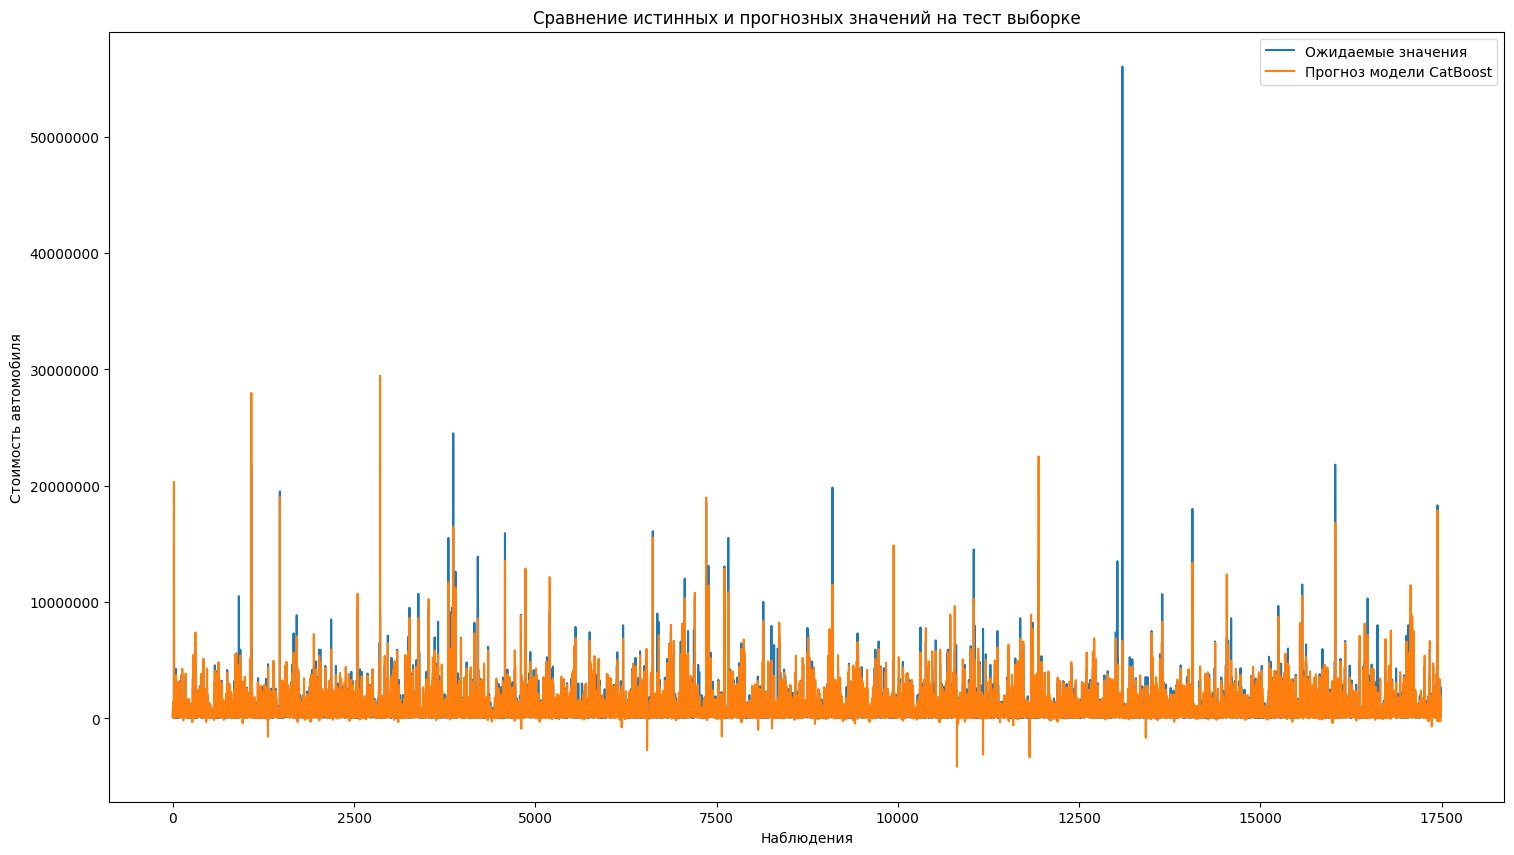

In [11]:
plt.figure(figsize=(18,10))
plt.title("Сравнение истинных и прогнозных значений на тест выборке")
plt.plot(y_true, label = 'Ожидаемые значения')
plt.plot(y_preds, label = 'Прогноз модели CatBoost')
plt.xlabel('Наблюдения')
plt.ylabel('Стоимость автомобиля')
plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

In [12]:
importances = model.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=["brand", "year", "mileage", "body_type", "fuel_type",
                       "engine_volume", "engine_power", "transmission","drive", "wheel",
                       "state", "owners_count", "pts", "customs", 'power_per_litre', 'mean_mileage_per_year'
                       ]).sort_values()

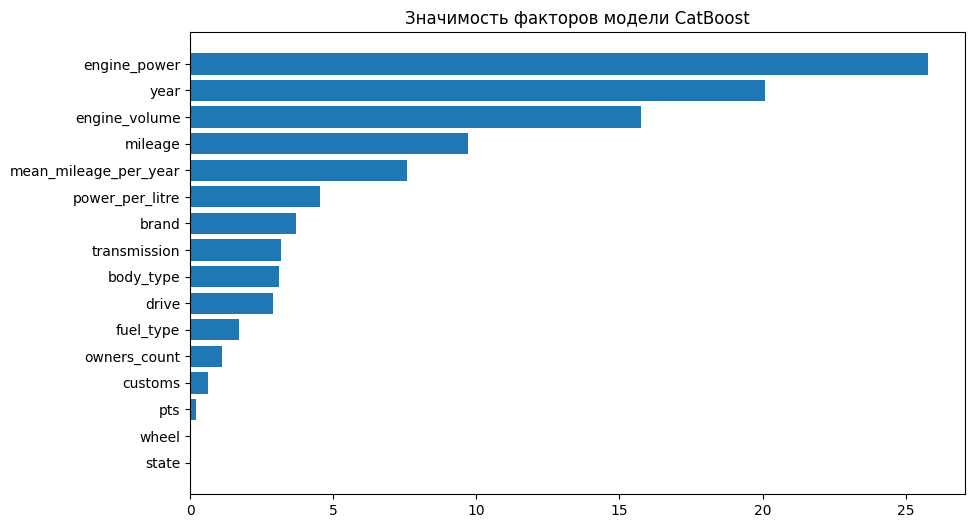

In [13]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('Значимость факторов модели CatBoost')
plt.show()

In [9]:
from catboost import CatBoostRegressor

# Initialize data

# Initialize data

train_data1 = [[1, 4, 5, 6],
                [4, 5, 6, 7],
                [30, 40, 50, 60]]
train_labels1 = [10, 20, 30]

train_data2 = [ [3, 7, 8, 9],
                [7, 8, 9, 10],
                [33, 43, 53, 63]]
train_labels2 = [13, 23, 33]


# initial parameters

model1 = CatBoostRegressor(iterations=5,
                           learning_rate=0.2,
                           depth=2)

model1.fit(train_data1, train_labels1)

# continue training with the same parameters, result will be in updated model1

model1.fit(train_data2, train_labels2, init_model=model1)


0:	learn: 7.7567175	total: 289us	remaining: 1.16ms
1:	learn: 7.3688816	total: 468us	remaining: 702us
2:	learn: 7.0404641	total: 626us	remaining: 417us
3:	learn: 6.7145278	total: 774us	remaining: 193us
4:	learn: 6.4154561	total: 2.34ms	remaining: 0us
0:	learn: 7.1999624	total: 444us	remaining: 1.78ms
1:	learn: 6.8399643	total: 778us	remaining: 1.17ms
2:	learn: 6.5926060	total: 1ms	remaining: 670us
3:	learn: 6.1968387	total: 1.16ms	remaining: 290us
4:	learn: 5.9729499	total: 1.41ms	remaining: 0us


In [2]:
from catboost import (CatBoostRegressor, Pool, sum_models,)

# Initialize data

train_data1 = [[1, 4, 5, 6],
                [4, 5, 6, 7],
                [30, 40, 50, 60]]
train_labels1 = [10, 20, 30]

train_data2 = [[3, 7, 8, 9],
                [7, 8, 9, 10],
                [33, 43, 53, 63]]
train_labels2 = [13, 23, 33]


# training parameters

params = {
    'iterations': 2,
    'learning_rate': 0.2,
    'depth': 2
}

model1 = CatBoostRegressor(**params)
batch1 = Pool(train_data1, label=train_labels1)
model1.fit(X=batch1)

# continue training with different portion of data

model2 = CatBoostRegressor(**params)
batch2 = Pool(train_data2, label=train_labels2)
batch2.set_baseline(model1.predict(batch2))
model2.fit(X=batch2)

# build resulting model

model = sum_models([model1, model2])


0:	learn: 7.7567175	total: 305us	remaining: 305us
1:	learn: 7.3688816	total: 782us	remaining: 0us
0:	learn: 7.8069852	total: 301us	remaining: 301us
1:	learn: 7.4166360	total: 501us	remaining: 0us
